<a href="https://colab.research.google.com/github/Uday-ashes-uday/deep-learning/blob/main/drone_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import os
from tqdm.notebook import tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

In [ ]:
from PIL import Image
import cv2
import albumentations as A

In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=957ed91647e69c21038f926b7b429c884979793022db44379a79d065e72c93ec
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=882ae821fae2829b3ae10490cde99a6bd6bc5c7d05dbc2aaa64d93bc09fb30ea
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!unzip '/content/drive/MyDrive/drone imagery.zip' -d /content/sample_data/drone

Archive:  /content/drive/MyDrive/drone imagery.zip
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: /content/sample_data/drone/RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflati

In [ ]:
#paths for images and labels

root_img_path='/content/sample_data/drone/dataset/semantic_drone_dataset/original_images'
root_label_path='/content/sample_data/drone/dataset/semantic_drone_dataset/label_images_semantic'

In [ ]:
data=pd.read_csv('/content/sample_data/drone/class_dict_seg.csv')

In [ ]:
image_list=[root_img_path+'/'+i for i in os.listdir(root_img_path)]
mask_list=[root_label_path +'/'+ i for i in os.listdir(root_label_path)]

In [ ]:
len(image_list),len(mask_list)

(400, 400)

In [ ]:
image_list_n=sorted(image_list)
mask_list_n=sorted(mask_list)


In [ ]:
image_list_n

['/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/000.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/001.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/002.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/003.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/004.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/005.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/006.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/008.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/011.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/013.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_dataset/original_images/014.jpg',
 '/content/sample_data/drone/dataset/semantic_drone_da

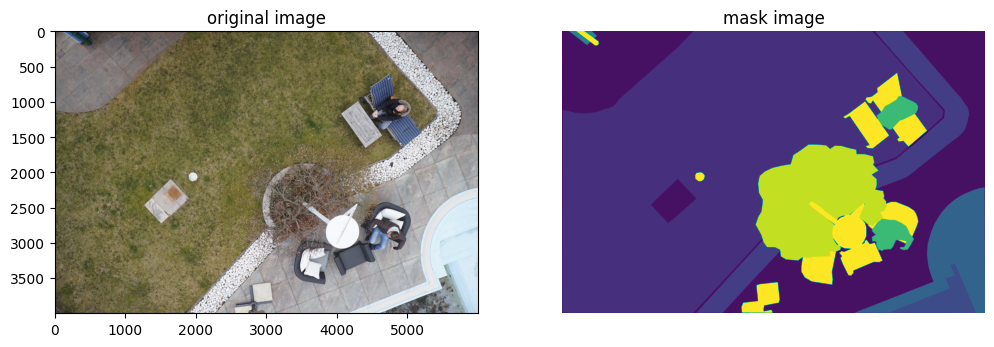

In [ ]:
import random
idx=random.randint(0,400)
im_x=plt.imread(image_list_n[idx])
im_y=plt.imread(mask_list_n[idx])

fig,ax=plt.subplots(1,2,figsize=(12,10))
plt.axis('off');
ax[0].imshow(im_x)
ax[0].set_title('original image')

ax[1].imshow(im_y)
ax[1].set_title('mask image')
plt.axis('off');

In [ ]:
label_data=pd.read_csv('/content/sample_data/drone/class_dict_seg.csv')

In [ ]:
len(label_data)

24

In [ ]:
from os.path import isfile,join

#return a df containing the image ids

def get_image_id_df(root_img_path):
  name=[]

  filenames=[f for f in os.listdir(root_img_path) if isfile(join(root_img_path,f))]
  for filename in filenames:
    name.append(filename.split('.')[0])
  return pd.DataFrame({'id':name},index=np.arange(0,len(name)))


In [ ]:
df=get_image_id_df(root_img_path)

In [ ]:
df.head(5)

,id
0,119
1,089
2,513
3,526
4,185


In [ ]:
#split into train and test

x_train_and_val,x_test=train_test_split(df['id'],test_size=0.1,random_state=42)

In [ ]:
x_train,x_val=train_test_split(x_train_and_val,test_size=0.1,random_state=42)

In [ ]:
len(x_train),len(x_val)

(324, 36)

In [ ]:
len(x_train_and_val),len(x_test)

(360, 40)

In [ ]:
#create dataset

class DataGet(Dataset):

  def __init__(self,img_path,mask_path,X,mean,std,transform=None,patch=False):
    self.img_path=img_path
    self.mask_path=mask_path
    self.X=X,
    self.mean=mean
    self.std=std
    self.transform=transform
    self.patches=patch

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    img=cv2.imread(self.img_path,self.X[idx]+'.jpg')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(self.mask_path,self.X[idx]+'.png'+cv2.IMREAD_GRAYSCALE)

    if self.transform is not None:
      aug=self.transform(image=img,mask=mask)
      img=Image.fromarray(aug['image'])
      mask=aug['mask']

    if self.transform is None:
      img=Image.fromarray(img)

    t=T.Compose([T.ToTensor(),T.Normalize(self.mean,self.std)])
    img=t(img)
    mask=torch.from_numpy(mask).long()

    if self.patches:
      img,mask=self.get_img_patches(img,mask)

  def get_img_patches(self,img,mask):
    """split images into patches of size (512,768)"""
    kh,kw=512,768 #kernel size
    dh,dw=512,768 #strides

    img_patches=img.unfold(1,kh,dh).unfold(2,kw,dw)

    img_patches=img_patches.contiguous().view(3,-1,kh,kw)

    img_patches=img_patches.permute(1,0,2,3)

    #do the same for masks

    mask_patches=mask.unfold(0,kh,dh).unfold(1,kw,dw)
    mask_patches=mask_patches.contiguous().view(-1,kh,kw)

    return img_patches,mask_patches








In [ ]:
model=smp.Unet('resnet34',encoder_weights='imagenet',classes=23,activation=None,
               encoder_depth=5,decoder_channels=[256,128,64,32,16])



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


In [ ]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
def pixel_accuracy(predicted_image,mask):
  """correctly predicted pixels by total number of pixels"""
  with torch.no_grad():
    predicted_image=torch.argmax(F.softmax(predicted_image,dim=1),dim=1)
    correct=torch.eq(predicted_image,mask).int()
    accuracy=float(correct.sum()/float(correct.numel()))

  return accuracy



In [ ]:
#mean IoU over the entire dataset should be calculated as follows

def mean_iou(predicted_label, label, eps=1e-10, num_classes=10):
    """
    Calculate the mean Intersection over Union (IoU) between the predicted labels and the ground truth labels.

    Args:
        predicted_label (torch.Tensor): Predicted label tensor of shape (N, C, H, W).
        label (torch.Tensor): Ground truth label tensor of shape (N, H, W).
        eps (float, optional): Epsilon value for numerical stability.
        num_classes (int, optional): Number of classes.

    Returns:
        float: Mean IoU value.

    """
    with torch.no_grad():
        # Convert predicted_label to class predictions
        predicted_label = F.softmax(predicted_label, dim=1)
        predicted_label = torch.argmax(predicted_label, dim=1)

        # Reshape predicted_label and label for easier computation
        predicted_label = predicted_label.contiguous().view(-1)
        label = label.contiguous().view(-1)

        iou_single_class = []
        for class_number in range(0, num_classes):
            true_predicted_class = predicted_label == class_number
            true_label = label == class_number

            if true_label.long().sum().item() == 0:
                iou_single_class.append(np.nan)
            else:
                # Calculate intersection and union
                intersection = (
                    torch.logical_and(true_predicted_class, true_label)
                    .sum()
                    .float()
                    .item()
                )
                union = (
                    torch.logical_or(true_predicted_class, true_label)
                    .sum()
                    .float()
                    .item()
                )

                # Calculate IoU for the current class
                iou = (intersection + eps) / (union + eps)
                iou_single_class.append(iou)

        # Calculate mean IoU across all classes
        return np.nanmean(iou_single_class)


In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [ ]:
def train(epochs,model,train_loader,val_loader,criterion,optimizer,scheduler,patch=False):
  torch.cuda.empty_cache()
  losses_train=[]
  losses_test=[]
  val_iou=[]
  val_acc=[]
  train_iou=[]
  train_acc=[]
  lrs=[]
  min_loss=np.inf
  decreases=1
  num_of_times_loss_not_improving=0

  model.to(device)



